# Mesh 2-pt calculations

This package includes mesh-based power spectrum and correlation function estimation.

## Power spectrum and correlation function from mesh

In [1]:
# Let's create some mesh mock!
import jax
from jax import numpy as jnp
from jaxpower import MeshAttrs, Spectrum2Poles, generate_anisotropic_gaussian_mesh


def get_theory(kmax=0.3, dk=0.001):
    # Return theory power spectrum
    from cosmoprimo.fiducial import DESI
    cosmo = DESI(engine='eisenstein_hu')
    z = 1.
    pk1d = cosmo.get_fourier().pk_interpolator().to_1d(z=z)
    ellsin = (0, 2, 4)
    edgesin = jnp.arange(0., kmax, dk)
    edgesin = jnp.column_stack([edgesin[:-1], edgesin[1:]])
    kin = (edgesin[..., 0] + edgesin[..., 1]) / 2.
    f, b = cosmo.growth_rate(z), 1.5
    beta = f / b
    shotnoise = (1e-3)**(-1)
    pk = pk1d(kin)
    poles = jnp.array([(1. + 2. / 3. * beta + 1. / 5. * beta ** 2) * pk + shotnoise,
                        0.99 * (4. / 3. * beta + 4. / 7. * beta ** 2) * pk,
                        8. / 35 * beta ** 2 * pk])
    return Spectrum2Poles(k=[kin] * len(ellsin), edges=[edgesin] * len(ellsin), num=list(poles), num_shotnoise=shotnoise, ells=ellsin)


attrs = MeshAttrs(boxsize=1000., meshsize=128)
poles = get_theory(4 * attrs.knyq.max())
mesh = generate_anisotropic_gaussian_mesh(attrs, poles, los='z', seed=68, order=1, unitary_amplitude=True)
print(mesh)

/local/home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmoprimo/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


RealMeshField(attrs=MeshAttrs(meshsize=staticarray([128, 128, 128], dtype=int32), boxsize=Array([1000., 1000., 1000.], dtype=float32), boxcenter=Array([0., 0., 0.], dtype=float32), dtype=dtype('float32'), fft_engine='jaxdecomp'))


In [2]:
# Now compute power spectrum
from jaxpower import compute_mesh2_spectrum, BinMesh2Spectrum

# This can be instantiated once for many power spectrum calculations as long as they share the same MeshAttrs
bin = BinMesh2Spectrum(attrs, edges={'step': 0.01}, ells=(0, 2, 4))

# One can jit the power spectrum calculation
compute = jax.jit(compute_mesh2_spectrum, static_argnames=['los'])

pk = compute(mesh, bin=bin, los='z')

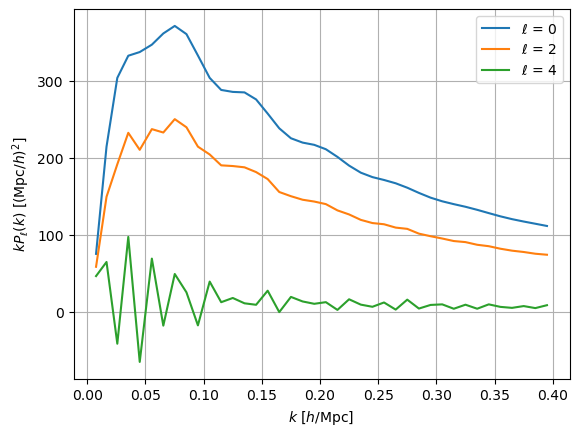

In [3]:
pk.plot(show=True);

In [4]:
# Now compute correlation function
from jaxpower import compute_mesh2_correlation, BinMesh2Correlation

# This can be instantiated once for many correlation function calculations as long as they share the same MeshAttrs
bin = BinMesh2Correlation(attrs, edges={'step': 5.}, ells=(0, 2, 4))

# One can jit the power spectrum calculation
compute = jax.jit(compute_mesh2_correlation, static_argnames=['los'])

xi = compute(mesh, bin=bin, los='z')

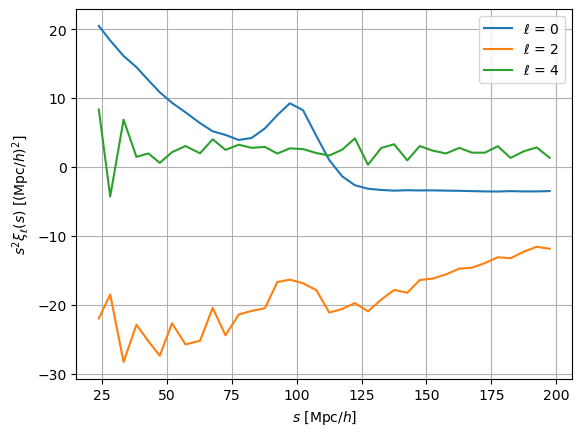

In [5]:
xi.select(xlim=(20., 200.)).plot(show=True);

In [6]:
# Everything above is transparently distributed
# Initialize JAX distributed environment
#jax.distributed.initialize()

# Let's simulate distributed calculation
from jaxpower import create_sharding_mesh

with create_sharding_mesh() as sharding_mesh:  # specify how to spatially distribute particles / mesh
    print('Sharding mesh {}.'.format(sharding_mesh))
    mesh = generate_anisotropic_gaussian_mesh(attrs, poles, los='z', seed=68, order=1, unitary_amplitude=True)
    bin = BinMesh2Spectrum(attrs, edges={'step': 0.01}, ells=(0, 2, 4))
    compute = jax.jit(compute_mesh2_spectrum, static_argnames=['los'])
    pk = compute(mesh, bin=bin, los='z')

# Close JAX distributed environment
#jax.distributed.shutdown()

Sharding mesh Mesh('x': 1, 'y': 1).


## Power spectrum and correlation function from particles (FKP)

In [7]:
# Let's create some particle mock!
from jaxpower import generate_uniform_particles

attrs = MeshAttrs(boxsize=1000., meshsize=128, boxcenter=700.)
poles = get_theory(4 * attrs.knyq.max())
# With local line-of-sight
mmesh = generate_anisotropic_gaussian_mesh(attrs, poles, los='local', seed=68, order=1, unitary_amplitude=True)

# Generate particles in smaller volume
pattrs = attrs.clone(boxsize=800.)
size = int(1e6)
data = generate_uniform_particles(pattrs, size, seed=42)
# Set weights = 1 + delta
data = data.clone(weights=1. + mmesh.read(data.positions, resampler='cic', compensate=True))

# Now randoms
randoms = generate_uniform_particles(pattrs, 2 * size, seed=43)

In [8]:
from jaxpower import FKPField, compute_fkp2_spectrum_normalization, compute_fkp2_spectrum_shotnoise, get_mesh_attrs

# Define MeshAttrs from positions
attrs = get_mesh_attrs(data.positions, randoms.positions, boxpad=2., meshsize=128)

fkp = FKPField(data, randoms, attrs=attrs)
norm, num_shotnoise = compute_fkp2_spectrum_normalization(fkp), compute_fkp2_spectrum_shotnoise(fkp)
# Paint particles to mesh
mesh = fkp.paint(resampler='tsc', interlacing=3, compensate=True, out='real')
del fkp
# Tip: can be done once for many P(k) evaluation
bin = BinMesh2Spectrum(attrs, edges={'step': 0.01}, ells=(0, 2, 4))
# Then compute power spectrum
# One can jit the function
compute = jax.jit(compute_mesh2_spectrum, static_argnames=['los'])
pk = compute(mesh, bin=bin, los='firstpoint')
# Add the normalization and shot noise information
pk = pk.clone(norm=norm, num_shotnoise=num_shotnoise)

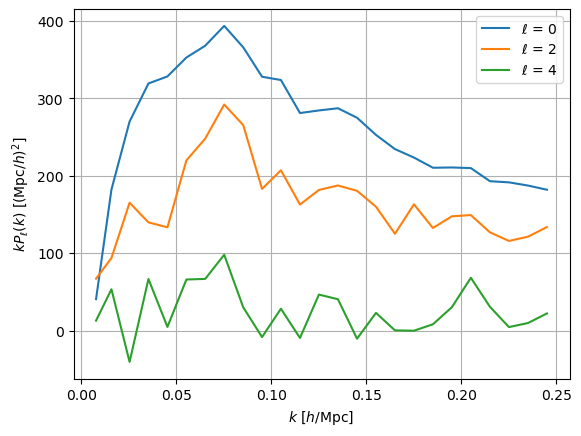

In [9]:
pk.plot(show=True);

In [10]:
# Now correlation function
bin = BinMesh2Correlation(attrs, edges={'step': 10.}, ells=(0, 2, 4))

compute = jax.jit(compute_mesh2_correlation, static_argnames=['los'])
xi = compute(mesh, bin=bin, los='firstpoint')
xi = xi.clone(norm=norm, num_shotnoise=num_shotnoise)

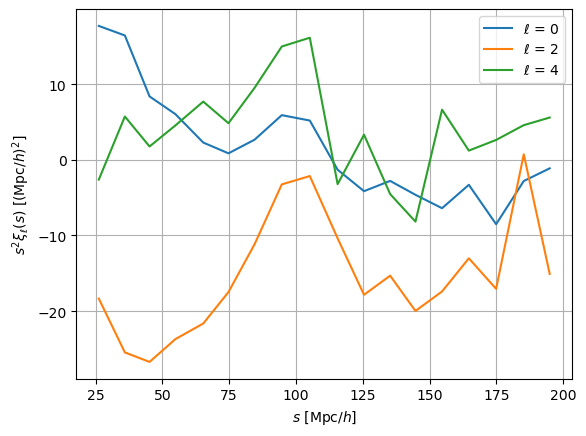

In [11]:
xi.select(xlim=(20., 200.)).plot(show=True);

In [12]:
# Initialize JAX distributed environment
#jax.distributed.initialize()

# Let's simulate distributed calculation
from jaxpower import create_sharding_mesh, exchange_particles, ParticleField

with create_sharding_mesh() as sharding_mesh:  # specify how to spatially distribute particles / mesh
    print('Sharding mesh {}.'.format(sharding_mesh))
    # Generate a Gaussian mock --- everything is already distributed
    attrs = MeshAttrs(boxsize=1000., meshsize=128, boxcenter=700.)
    mmesh = generate_anisotropic_gaussian_mesh(attrs, poles, los='local', seed=68, order=1, unitary_amplitude=True)
    pattrs = attrs.clone(boxsize=800.)
    size = int(1e6)
    data = generate_uniform_particles(pattrs, size, seed=42)
    data = data.clone(weights=1. + mmesh.read(data.positions, resampler='cic', compensate=True))
    randoms = generate_uniform_particles(pattrs, 2 * size, seed=43)

    # Now, pick MeshAttrs
    attrs = get_mesh_attrs(data.positions, randoms.positions, boxpad=2., meshsize=128)
    # And exchange particles
    positions, exchange = exchange_particles(attrs, data.positions)
    weights = exchange(data.weights)
    data = ParticleField(positions, weights, attrs=attrs)
    positions, exchange = exchange_particles(attrs, randoms.positions)
    weights = exchange(randoms.weights)
    randoms = ParticleField(positions, weights, attrs=attrs)
    
    # Now data and randoms are exchanged given MeshAttrs attrs, we can proceed as normal
    fkp = FKPField(data, randoms, attrs=attrs)
    norm, num_shotnoise = compute_fkp2_spectrum_normalization(fkp), compute_fkp2_spectrum_shotnoise(fkp)
    mesh = fkp.paint(resampler='tsc', interlacing=3, compensate=True, out='real')
    del fkp
    bin = BinMesh2Spectrum(attrs, edges={'step': 0.01}, ells=(0, 2, 4))
    pk = compute(mesh, bin=bin, los='firstpoint')
    pk = pk.clone(norm=norm, num_shotnoise=num_shotnoise)

# Close JAX distributed environment
#jax.distributed.shutdown()

Sharding mesh Mesh('x': 1, 'y': 1).
